<a href="https://colab.research.google.com/github/TimurMMD/NN_projects/blob/main/Polynomial_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This project was created for learning purposes to practice building a simple neural network.
## As a task was taken to create polynomials and to learn parameters as closely as possible.
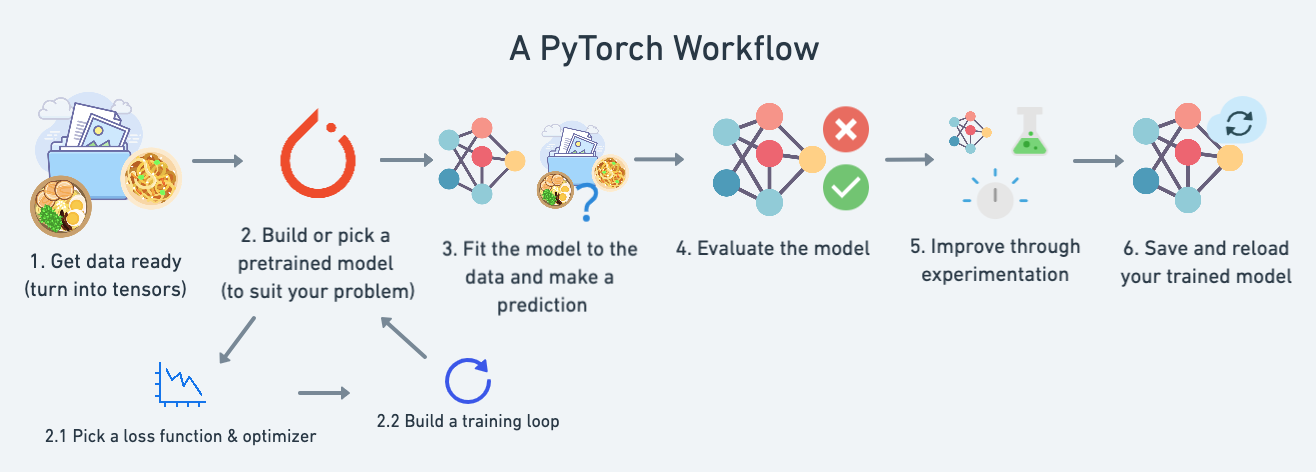

## The picture above represents pytorch workflow of creating NN. This is exactly what I focused on during this project.



In [16]:
# Import libraries
import torch
from torch import nn
import matplotlib.pyplot as plt

In [17]:
# Check the version
torch.__version__

'2.3.1+cu121'

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [19]:
# Create parameters for the model
weight_0 = 15.67
weight_1 = -7.75
weight_2 = 5.53
bias = -20.12

# Create data
start = 0
end = 2
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight_0 * X + weight_1 * X**2 + weight_2 * X**3 + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[-20.1200],
         [-19.8097],
         [-19.5052],
         [-19.2065],
         [-18.9132],
         [-18.6250],
         [-18.3416],
         [-18.0629],
         [-17.7885],
         [-17.5182]]))

In [20]:
# Make train and test data
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [21]:
len(X_train), len(X_test), len(y_train), len(y_test)

(80, 20, 80, 20)

In [22]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 6))
  plt.grid(which='both')

  # Plot training data
  plt.plot(train_data, train_labels, c='g', linewidth = 3, label='Training plot')

  # Plot test data
  plt.plot(test_data, test_labels, c='b', marker='o',markersize=4.0, label='Testing plot')

  # Plot predictions
  if predictions is not None:
    plt.plot(test_data, predictions, c='r', marker='x', label='Predictions')

  plt.legend(prop={'size': 14})


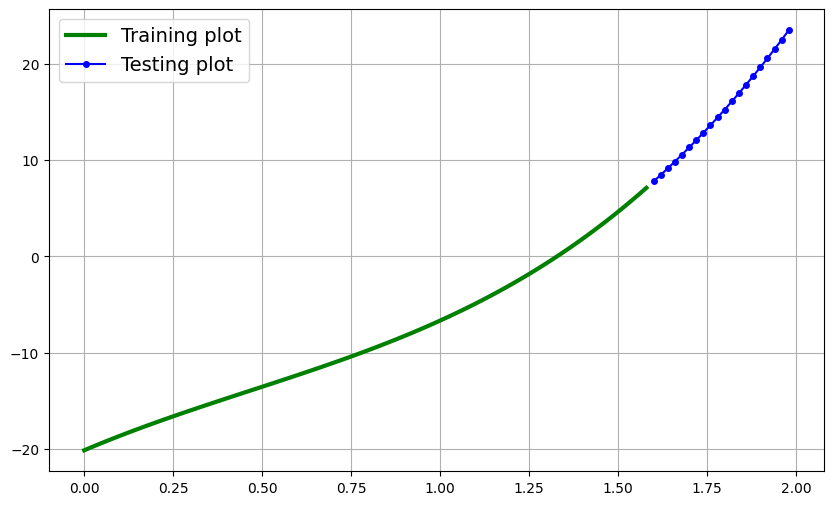

In [23]:
plot_predictions()

In [54]:
# # Create model
# import torch.nn.functional as F

# class PolynomialRegression(nn.Module):
#   def __init__(self):
#     super().__init__()

#     # Use Linear layers to create model
#     #self.linear_0 = nn.Linear(in_features=1, out_features=12)
#     #self.linear_1 = nn.Linear(in_features=12, out_features=4)
#     #self.linear_2 = nn.Linear(in_features=4, out_features=1)
#     #self.activation = nn.ReLU()

#   def forward(self, x: torch.Tensor) -> torch.Tensor: # input is tensor and output is a tensor too
#     x = F.relu(self.linear_0(x))
#     x = F.relu(self.linear_1(x))
#     x = self.linear_2(x)

#     return x

The NN with Linear layers didn't reach desired accuracy.
Create a new model with custom polynomial layers.

In [145]:
# Define class of custom polynomial layer with the parameters and the function
class PolynomialLayer(nn.Module):
  def __init__(self):
    super().__init__()
    # Define parameters fro the model
    self.w1 = nn.Parameter(torch.randn(1)) # Weight for X1
    self.w2 = nn.Parameter(torch.randn(1)) # weight for X2
    self.w3 = nn.Parameter(torch.randn(1)) # weight for X3
    self.bias = nn.Parameter(torch.randn(1)) # bias

  def forward(self, x):
    y = self.w1*x + self.w2*x**2 + self.w3*x**3 + self.bias
    return y

# Create the polynomial model with custom layer and the linear layer
class PolynomialModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.poly_layer = PolynomialLayer()
    # self.hidden_layer = nn.Linear(in_features=1, out_features=12)
    # self.output_layer = nn.Linear(in_features=12, out_features=1)
    #self.activation = nn.ReLU()

  def forward(self, x):
    x = self.poly_layer(x)
    # x = self.activation(self.hidden_layer(x))
    # x = self.output_layer(x)
    return x

In [160]:
model = PolynomialModel()
model, model.state_dict()

(PolynomialModel(
   (poly_layer): PolynomialLayer()
 ),
 OrderedDict([('poly_layer.w1', tensor([-0.6892])),
              ('poly_layer.w2', tensor([0.8368])),
              ('poly_layer.w3', tensor([-0.4159])),
              ('poly_layer.bias', tensor([-1.8798]))]))

The model has created some random parameters of weights and bias

In [161]:
# Check the device
next(model.parameters()).device

device(type='cpu')

In [162]:
# Change it to work in gpu
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

Make a training and test loops

In [163]:
# Create a Loss function to measure the errorness of the model during training
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.01,
                            momentum=0.9)



In [164]:
epochs = 10000

# Transfer data to available device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Training loop
for epoch in range(epochs):
  ### Put model to the training mode
  model.train()

  # 1. Forward pass
  y_pred = model(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  # 3. Zero grad optimizer
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  # Testing part

  ### Put model to testing mode
  model.eval()

  # 1. Forward pass
  with torch.inference_mode():
    test_pred = model(X_test)

    # 2. Calculate the loss
    loss_test = loss_fn(test_pred, y_test)

  if epoch % 1000 == 0:
   print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {loss_test}")

Epoch: 0 | Train loss: 8.640061378479004 | Test loss: 17.932083129882812
Epoch: 1000 | Train loss: 0.44301339983940125 | Test loss: 1.8975805044174194
Epoch: 2000 | Train loss: 0.34258145093917847 | Test loss: 2.8800125122070312
Epoch: 3000 | Train loss: 0.301547110080719 | Test loss: 2.564847946166992
Epoch: 4000 | Train loss: 0.2606900632381439 | Test loss: 2.2217631340026855
Epoch: 5000 | Train loss: 0.21980607509613037 | Test loss: 1.8673927783966064
Epoch: 6000 | Train loss: 0.1789296567440033 | Test loss: 1.5222454071044922
Epoch: 7000 | Train loss: 0.13806569576263428 | Test loss: 1.180436372756958
Epoch: 8000 | Train loss: 0.09719673544168472 | Test loss: 0.8310009837150574
Epoch: 9000 | Train loss: 0.05635653808712959 | Test loss: 0.4840751588344574


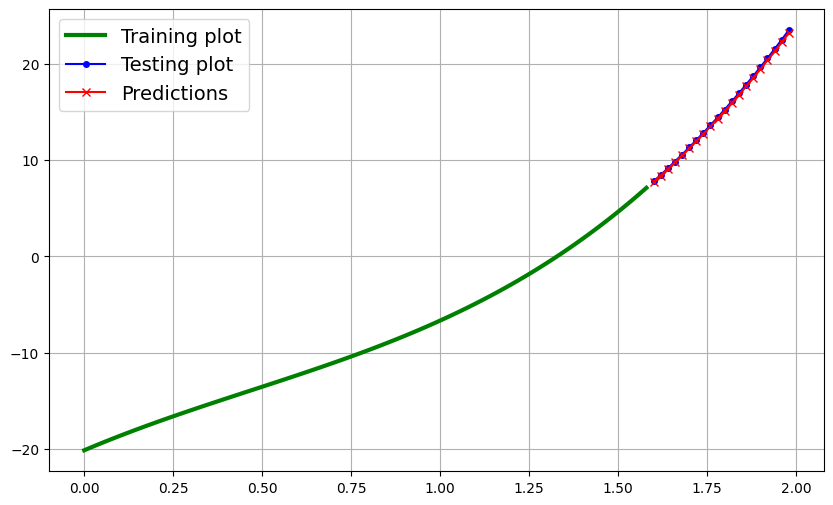

In [165]:
plot_predictions(predictions=test_pred.cpu())

In [166]:
from pprint import pprint
print("The model's learned parameters are:")
pprint(model.state_dict())
print("\nAnd the original parameters are:")
print(f"weights: {weight_0}, {weight_1}, {weight_2}")
print(f"bias: {bias}")

The model's learned parameters are:
OrderedDict([('poly_layer.w1', tensor([15.2434], device='cuda:0')),
             ('poly_layer.w2', tensor([-7.1643], device='cuda:0')),
             ('poly_layer.w3', tensor([5.2995], device='cuda:0')),
             ('poly_layer.bias', tensor([-20.0419], device='cuda:0'))])

And the original parameters are:
weights: 15.67, -7.75, 5.53
bias: -20.12


As we can see the learned parameters are quite close to the original one.
The variables to achieve that are:
- epochs: 10000
- learning rate: 0.01
- momentum: 0.9

In [167]:
# Saving the model
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "polynomial_nn_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)


Saving model to: models/polynomial_nn_model.pth


In [169]:
# Load the model
loaded_model = PolynomialModel()
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model.to(device)
print(f"Loaded mdel:\n {loaded_model}")
print(f"Model on device:\n {next(loaded_model.parameters()).device}")

Loaded mdel:
 PolynomialModel(
  (poly_layer): PolynomialLayer()
)
Model on device:
 cuda:0


In [171]:
# Checl if the loaded model is correct
loaded_model.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model(X_test)
test_pred == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

## Summary
The Polynomial Neural Network model has been created, trained and evaluated.
The learned parameters match the original ones. During this learning experiment was discovered that in order of reaching better results it is better to use custom NN rather then Linear layers. However, in most cases it's hard to determine the function that would describe the pattern better and it is a good manner to use standard torch layers inside the model.
In the end, the model was saved and checked if the saving was correct.

